In [1]:
import fromscratchtoml
fromscratchtoml.use("numpy")
# fromscratchtoml.use("cupy")

from fromscratchtoml.neural_network.models import Sequential
from fromscratchtoml.neural_network.optimizers import StochasticGradientDescent, Adagrad, RMSprop, Adam
from fromscratchtoml.neural_network.layers import Dense, Activation, Dropout
from fromscratchtoml.neural_network.regularizers import l1, l2, l1_l2

import numpy as np
# import cupy as np

from sklearn.model_selection import train_test_split

from fromscratchtoml.toolbox.random import Distribution
from fromscratchtoml.toolbox.preprocess import to_onehot


In [2]:
from sklearn import datasets
from sklearn.utils import shuffle

from fromscratchtoml.toolbox import binary_visualize

%matplotlib inline

# Neural Networks

## MNIST Digit Classification

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home=".")
print(len(mnist.data))
X2 = mnist.data/256.
mnist.target.__class__
y2 = to_onehot(mnist.target)

70000


In [4]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=10000, random_state=42)
X_train2.shape, y_train2.shape, X_train2.dtype

((60000, 784), (60000, 10), dtype('float64'))

In [5]:
model2 = Sequential(verbose=1,vis_loss=1)
# model2.add(Dropout(0.2, seed=0))

model2.add(Dense(30, input_dim=784, seed=1))
model2.add(Activation('relu'))
# model2.add(Dropout(0.2, seed=2))

# model2.add(Dense(30))
# model2.add(Activation('relu'))
# model2.add(Dropout(0.2, seed=4))

model2.add(Dense(10, seed=2))
# model2.add(Activation('softmax'))
# model2.add(Activation('sigmoid'))

opt = StochasticGradientDescent(learning_rate=0.05, momentum=0., nesterov=0)
# opt = Adagrad(learning_rate=0.2)
# opt = RMSprop(learning_rate=0.001, decay=0.9)
# opt = Adam(learning_rate=0.001, bias_fix=0)
model2.compile(optimizer=opt, loss="mean_squared_error")


epoch: 1/10  loss: 0.257  acc1: 76.14 
[████                                    ] 10% 
epoch: 2/10  loss: 0.214  acc1: 83.17 
[████████                                ] 20% 
epoch: 3/10  loss: 0.190  acc1: 85.97 
[████████████                            ] 30% 
epoch: 4/10  loss: 0.173  acc1: 87.42 
[████████████████                        ] 40% 
epoch: 5/10  loss: 0.159  acc1: 88.35 
[████████████████████                    ] 50% 
epoch: 6/10  loss: 0.150  acc1: 88.97 
[████████████████████████                ] 60% 
epoch: 7/10  loss: 0.142  acc1: 89.37 
[████████████████████████████            ] 70% 
epoch: 8/10  loss: 0.136  acc1: 89.63 
[████████████████████████████████        ] 80% 
epoch: 9/10  loss: 0.131  acc1: 89.85 
[████████████████████████████████████    ] 90% 
epoch: 10/10  loss: 0.126  acc1: 90.02 
[████████████████████████████████████████] 100% 

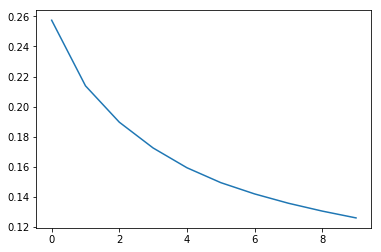

CPU times: user 40.8 s, sys: 18.2 s, total: 59 s
Wall time: 7.85 s


In [6]:
%time model2.fit(X_train2, y_train2, batch_size=256, epochs=10)

In [7]:
model2.accuracy(X_test2, y_test2)

89.98

In [8]:
p90

NameError: name 'p90' is not defined

## Regression

In [ ]:
x_train = np.random.rand(100)
x_train = np.expand_dims(x_train, axis=1)
y_train=x_train**4

x_test=np.linspace(0,1,9)
y_test=x_test**4

In [ ]:
model3 = Sequential(verbose=0, vis_loss=1)
model3.add(Dense(units=100, input_dim=1, seed=10))
model3.add(Activation('relu'))
model3.add(Dense(units=45, seed=2))
model3.add(Activation('relu'))
model3.add(Dense(units=1, seed=2))

sgd = StochasticGradientDescent(learning_rate=0.05)
model3.compile(optimizer=sgd, loss="mean_squared_error", accuracy_metric="regression")

%time model3.fit(x_train, y_train, epochs=1000)

In [ ]:
y_pred = model3.predict(x_test, prob=1)
y_pred[:5]

In [ ]:
y_test[:5]

## Radial

In [ ]:
X11 = Distribution.radial_binary(pts=300,
               mean=[0, 0],
               st=1,
               ed=2, seed=20)
X22 = Distribution.radial_binary(pts=300,
               mean=[0, 0],
               st=4,
               ed=5, seed=20)

Y11 = np.ones(X11.shape[0])
Y22 = np.zeros(X11.shape[0])

X5 = np.vstack((X11, X22))
y5 = np.hstack((Y11, Y22))

In [ ]:
y5 = to_onehot(y5)

In [ ]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=50, random_state=42)

In [ ]:
y_train5.shape

In [ ]:
model5 = Sequential(verbose=1, vis_each_epoch=True)
model5.add(Dense(10, input_dim=2, seed=1))
model5.add(Activation('sigmoid'))
model5.add(Dense(2, seed=2))
model5.add(Activation('sigmoid'))
model5.add(Dense(2, seed=3))
model5.add(Activation('sigmoid'))
sgd = StochasticGradientDescent(learning_rate=0.9)
model5.compile(optimizer=sgd, loss="mean_squared_error")

In [ ]:
X_train5[0]

In [ ]:
%time model5.fit(X_train5, y_train5, batch_size=4, epochs=10)

In [ ]:
binary_visualize(X_test5, clf=model5, draw_contour=True)